In [1]:
import pandas as pd
import json

In [2]:
import os
if 'R_HOME' not in os.environ:
  os.environ['R_HOME'] = '/usr/lib/R'

In [3]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Setting LC_CTYPE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 4: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinte

In [4]:
def convert_list_of_dicts_into_dataframe(dict_list):
  output = {}
  for keyname in dict_list[0].keys():
    output[keyname] = []
  for item in dict_list:
    for k,v in item.items():
      output[k].append(v)
  return pd.DataFrame.from_dict(output)

#print(convert_list_of_dicts_into_dataframe([
#  {'a': 3, 'b': 5},
#  {'a': 4, 'b': 6}
#]))

In [5]:
sessions_for_user_by_day_and_goal_for_all_users = json.load(open('browser_all_session_info_sept18_v4.json'))

In [6]:
def compute_intensity(domains_and_sessions):
  #print(domains_and_sessions)
  number_of_sessions_total = 0
  number_of_sessions_where_intervention_was_seen = 0
  for domain_and_sessions in domains_and_sessions:
    domain = domain_and_sessions['domain']
    is_goal_enabled = domain_and_sessions['is_goal_enabled']
    is_goal_frequent = domain_and_sessions['is_goal_frequent']
    if not is_goal_enabled:
      continue
    for session_info in domain_and_sessions['session_info_list_for_domain']:
      number_of_sessions_total += 1
      if session_info['intervention_active'] != None:
        number_of_sessions_where_intervention_was_seen += 1
  if number_of_sessions_total == 0:
    return None
  return number_of_sessions_where_intervention_was_seen / number_of_sessions_total

def compute_intensity_other_goal_domains(domains_and_sessions, target_domain):
  number_of_sessions_total = 0
  number_of_sessions_where_intervention_was_seen = 0
  for domain_and_sessions in domains_and_sessions:
    domain = domain_and_sessions['domain']
    if domain == target_domain:
      continue
    is_goal_enabled = domain_and_sessions['is_goal_enabled']
    is_goal_frequent = domain_and_sessions['is_goal_frequent']
    if not is_goal_enabled:
      continue
    for session_info in domain_and_sessions['session_info_list_for_domain']:
      number_of_sessions_total += 1
      if session_info['intervention_active'] != None:
        number_of_sessions_where_intervention_was_seen += 1
  if number_of_sessions_total == 0:
    return None
  return number_of_sessions_where_intervention_was_seen / number_of_sessions_total

def test_compute_intensity():
  for sessions_for_user_by_day_and_goal in sessions_for_user_by_day_and_goal_for_all_users:
    user = sessions_for_user_by_day_and_goal['user']
    for day_domains_and_sessions in sessions_for_user_by_day_and_goal['days_domains_and_sessions']:
      #if day_domains_and_sessions['is_goal_enabled'] != True:
      #  continue
      if True not in ([x['is_goal_enabled'] for x in day_domains_and_sessions['domains_and_sessions']]):
        continue
      print(compute_intensity(day_domains_and_sessions['domains_and_sessions']))
      return
#test_compute_intensity()

In [7]:
# def compute_have_preview_sessions_today(domain_and_sessions):
#   print(domain_and_sessions)

# def test_compute_have_preview_sessions_today():
#   for sessions_for_user_by_day_and_goal in sessions_for_user_by_day_and_goal_for_all_users:
#     user = sessions_for_user_by_day_and_goal['user']
#     for day_domains_and_sessions in sessions_for_user_by_day_and_goal['days_domains_and_sessions']:
#       #if day_domains_and_sessions['is_goal_enabled'] != True:
#       #  continue
#       if True not in ([x['is_goal_enabled'] for x in day_domains_and_sessions['domains_and_sessions']]):
#         continue
#       for domain_and_sessions in day_domains_and_sessions['domains_and_sessions']:
#         print(compute_have_preview_sessions_today(domain_and_sessions))
#         return

# test_compute_have_preview_sessions_today()

In [8]:


# def print_data_for_users():
#   for sessions_for_user_by_day_and_goal in sessions_for_user_by_day_and_goal_for_all_users:
#     user = sessions_for_user_by_day_and_goal['user']
#     if user == '6216c587462fb5fa9ca9f0e9':
#       print(sessions_for_user_by_day_and_goal)
# print_data_for_users()

In [80]:
def passes_filters(filter_funcs, item):
  for filter_func in filter_funcs:
    if not filter_func(item):
      return False
  return True

def difference_ratio(a, b):
  diff = abs(a - b)
  smaller = min(abs(a), abs(b))
  if smaller == 0:
    return 1
  return diff / smaller

def compute_have_preview_sessions_today(session_info_list):
  for session_info in session_info_list:
    if 'is_preview_mode' in session_info and session_info['is_preview_mode'] == True:
      return True
  return False

def compute_have_suggestion_sessions_today(session_info_list):
  for session_info in session_info_list:
    if 'is_suggestion_mode' in session_info and session_info['is_suggestion_mode'] == True:
      return True
  return False

def make_dictlist_days(sessions_for_user_by_day_and_goal_for_all_users, item_filter_funcs=[], day_filter_funcs=[], user_filter_funcs=[]):
  output = []
  num_consistent = 0
  num_inconsistent = 0
  num_consistent_users = 0
  num_inconsistent_users = 0
  num_consistent_user_items = 0
  num_inconsistent_user_items = 0
  num_consistent_days = 0
  num_inconsistent_days = 0
  num_consistent_day_items = 0
  num_inconsistent_day_items = 0
  for sessions_for_user_by_day_and_goal in sessions_for_user_by_day_and_goal_for_all_users:
    user = sessions_for_user_by_day_and_goal['user']
    is_user_unofficial = sessions_for_user_by_day_and_goal['is_user_unofficial']
    if not passes_filters(user_filter_funcs, sessions_for_user_by_day_and_goal):
      continue
    num_days_available_for_user = len(sessions_for_user_by_day_and_goal['days_domains_and_sessions'])
    output_for_user = []
    #epoch_list = [x['epoch'] for x in sessions_for_user_by_day_and_goal['days_domains_and_sessions']]
    #first_epoch_for_user = min(epoch_list)
    #last_epoch_for_user = max(epoch_list)
    for day_domains_and_sessions in sessions_for_user_by_day_and_goal['days_domains_and_sessions']:
      output_for_day = []
      epoch = day_domains_and_sessions['epoch']
      #day_domains_and_sessions['days_since_install'] = epoch - first_epoch_for_user
      #day_domains_and_sessions['days_until_last'] = last_epoch_for_user - epoch
      if not passes_filters(day_filter_funcs, day_domains_and_sessions):
        continue
      intensity = compute_intensity(day_domains_and_sessions['domains_and_sessions'])
      for domain_and_sessions in day_domains_and_sessions['domains_and_sessions']:
        domain = domain_and_sessions['domain']
        have_preview_sessions = compute_have_preview_sessions_today(domain_and_sessions['session_info_list_for_domain'])
        have_suggestion_sessions = compute_have_suggestion_sessions_today(domain_and_sessions['session_info_list_for_domain'])
        num_sessions_today_for_this_goal = len(domain_and_sessions['session_info_list_for_domain'])
        intensity_other_goals = compute_intensity_other_goal_domains(day_domains_and_sessions['domains_and_sessions'], domain)
        time_on_domain_today = domain_and_sessions['time_on_domain_today']
        time_on_domain_today_ref = domain_and_sessions['time_on_domain_today_ref']
        time_on_all_other_domains_today = domain_and_sessions['time_on_all_other_domains_today']
        time_on_all_other_domains_today_ref = domain_and_sessions['time_on_all_other_domains_today_ref']
        time_on_other_goal_domains_today = domain_and_sessions['time_on_other_goal_domains_today']
        time_on_other_goal_domains_today_ref = domain_and_sessions['time_on_other_goal_domains_today_ref']
        is_goal_enabled = domain_and_sessions['is_goal_enabled']
        is_goal_frequent = domain_and_sessions['is_goal_frequent']
        #if is_goal_enabled and difference_ratio(time_on_domain_today, time_on_domain_today_ref) > 0.2:
        #  num_inconsistent += 1
        #  #if num_inconsistent < 10:
        #  #  print(domain_and_sessions)
        #  #  print('\n')
        #  #else:
        #  #  return
        #  continue
        #if is_goal_enabled and difference_ratio(time_on_all_other_domains_today, time_on_all_other_domains_today_ref) > 0.2:
        #  num_inconsistent += 1
        #  continue
        #if is_goal_enabled and difference_ratio(time_on_other_goal_domains_today, time_on_other_goal_domains_today_ref) > 0.2:
        #  num_inconsistent += 1
        #  continue
        #if is_goal_enabled:
        #  num_consistent += 1
        newitem = {
          'user': user,
          'epoch': epoch,
          'domain': domain,
          'time_on_domain_today': time_on_domain_today,
          'time_on_domain_today_ref': time_on_domain_today_ref,
          'time_on_all_other_domains_today': time_on_all_other_domains_today,
          'time_on_all_other_domains_today_ref': time_on_all_other_domains_today_ref,
          'time_on_all_other_domains_today_max': max(time_on_all_other_domains_today_ref, time_on_all_other_domains_today),
          'time_on_other_goal_domains_today': time_on_other_goal_domains_today,
          'time_on_other_goal_domains_today_ref': time_on_other_goal_domains_today_ref,
          'time_on_other_goal_domains_today_max': max(time_on_other_goal_domains_today_ref, time_on_other_goal_domains_today),
          'is_goal_enabled': is_goal_enabled,
          'is_goal_frequent': is_goal_frequent,
          'intensity': intensity,
          'intensity_other_goals': intensity_other_goals,
          'num_days_available_for_user': num_days_available_for_user,
          'is_user_unofficial': is_user_unofficial,
          'have_preview_sessions': have_preview_sessions,
          'have_suggestion_sessions': have_suggestion_sessions,
          'num_sessions_today_for_this_goal': num_sessions_today_for_this_goal,
        }
        if not consistent_days_only(newitem):
          newitem['consistent_item'] = False
          #print(newitem)
          #print(domain_and_sessions)
          #return
        else:
          newitem['consistent_item'] = True
        #if is_goal_enabled:
        #  if not consistent_days_only(newitem):
        #    num_inconsistent += 1
        #    continue
        #  num_consistent += 1
        if not passes_filters(item_filter_funcs, newitem):
          continue
        output_for_day.append(newitem)
      is_day_inconsistent = False
      for item in output_for_day:
        if not consistent_days_only(item):
          is_day_inconsistent = True
      for item in output_for_day:
        item['consistent_day'] = not is_day_inconsistent
      exclude_inconsistent_days = False
      if exclude_inconsistent_days:
        if not is_day_inconsistent:
          num_consistent_days += 1
          num_consistent_day_items += len(output_for_day)
          for item in output_for_day:
            output_for_user.append(item)
        else:
          num_inconsistent_days += 1
          num_inconsistent_day_items += len(output_for_day)
      else:
        for item in output_for_day:
          output_for_user.append(item)
    is_user_inconsistent = False
    for item in output_for_user:
      if not consistent_days_only(item):
        is_user_inconsistent = True
    for item in output_for_user:
      item['consistent_user'] = not is_user_inconsistent
    exclude_inconsistent_users = False
    if exclude_inconsistent_users:
      if not is_user_inconsistent:
        num_consistent_users += 1
        num_consistent_user_items += len(output_for_user)
        for item in output_for_user:
          output.append(item)
      else:
        num_inconsistent_users += 1
        num_inconsistent_user_items += len(output_for_user)
    else:
      for item in output_for_user:
        output.append(item)
  print('num consistent ' + str(num_consistent))
  print('num inconsistent ' + str(num_inconsistent))
  print('num consistent users ' + str(num_consistent_users))
  print('num inconsistent users ' + str(num_inconsistent_users))
  print('num consistent user items ' + str(num_consistent_user_items))
  print('num inconsistent user items ' + str(num_inconsistent_user_items))
  print('num consistent days ' + str(num_consistent_days))
  print('num inconsistent days ' + str(num_inconsistent_days))
  print('num consistent day items ' + str(num_consistent_day_items))
  print('num inconsistent day items ' + str(num_inconsistent_day_items))
  return output

def make_dataframe_days(sessions_for_user_by_day_and_goal_for_all_users, item_filter_funcs=[], day_filter_funcs=[], user_filter_funcs=[]):
  #sessions_for_user_by_day_and_goal_for_all_users = get_sessions_for_user_by_day_and_goal_for_all_users()
  output = make_dictlist_days(sessions_for_user_by_day_and_goal_for_all_users, item_filter_funcs, day_filter_funcs, user_filter_funcs)
  return convert_list_of_dicts_into_dataframe(output)

def consistent_days_only(x):
  is_goal_enabled = x['is_goal_enabled']
  time_on_domain_today = x['time_on_domain_today']
  time_on_domain_today_ref = x['time_on_domain_today_ref']
  time_on_all_other_domains_today = x['time_on_all_other_domains_today']
  time_on_all_other_domains_today_ref = x['time_on_all_other_domains_today_ref']
  time_on_other_goal_domains_today = x['time_on_other_goal_domains_today']
  time_on_other_goal_domains_today_ref = x['time_on_other_goal_domains_today_ref']
  if is_goal_enabled and difference_ratio(time_on_domain_today, time_on_domain_today_ref) > 0.1:
    return False
  if is_goal_enabled and difference_ratio(time_on_all_other_domains_today, time_on_all_other_domains_today_ref) > 0.1:
    return False
  if is_goal_enabled and difference_ratio(time_on_other_goal_domains_today, time_on_other_goal_domains_today_ref) > 0.1:
    return False
  return True

# item filter funcs
def enabled_goals_only(x):
  return x['is_goal_enabled'] == True

# day filter funcs
def not_first_day(x):
  return x['days_since_install'] != 0

def not_last_day(x):
  return x['days_until_last'] != 0

# user filter funcs
def at_least_two_days(x):
  return len(x['days_domains_and_sessions']) > 1

def at_least_two_weeks(x):
  #print(len(x))
  return len(x['days_domains_and_sessions']) > 13

def exclude_blacklist(x):
  return True
  blacklist = [
    # users who changed their clock while using habitlab
    '6216c587462fb5fa9ca9f0e9',
    'b3f8a7df8e4aec23e62f7cc7',
    'a80b94f6cad4a1280dfe935a',
    '42932100873bd6c4750026a8'
  ]
  # users with too long things
  blacklist.extend(['6232e889000db7282a3cd7ee', '72cf3e73e5e4ef20e77015e7',
       '7c0c0ad786467732ee15d9b6', 'b589bdfd7b95a271d5673bf0',
       'a3cf5d18447d24cb05b18728', '11078c6dbf8bbc818a6357a9',
       '9fedb69588eb607849fbd126', '378f28934b3e04b9a7231748'
  ])
  blacklist.extend(['b96c4f7eef2ab6d081013d3b', '17e7de4f422a37ce6b911178',
       'ed86421a4167fd4d84b5dc4a', '413790b746780d4712adad4b',
       'a09f4d8b6326097b44238b62', '51a6d0a3a33e937927f6b8b9',
       '5c5f6cb12fc0f69fc739d34d', 'd16a122ead215d892cd95868',
       'ed1649f8ba47ece26dd14380', '18d5f3a11194e06a1a802d90',
       'fecd855dea0b5cbbbbced63f', 'd4067837e8d0a0c192881d57',
       'b2d4727b7b860e1dd8c006f1', '0386c60fadc95024a795ee28',
       '5e74926590582e9f959b47c8', '055bdc7d333c545546f4e555',
       '2e2f1b26e1e387f1929d1038', '4f8f02fd03f53cb7715cda29',
       'a8f400e1c3b6209200924e86', 'c73a3543e22618ae52c3d0f4',
       'e9c030c0e3b1746223357d46', 'c00429a895c7d735aa461dab',
       '340c0d124ffc2d27b34224de', 'd553788cc3f63b4e9f8f49b4',
       '636db39680b04864732c9513', 'c8d66c0d7b3573ad940047e7',
       'd936520e1e4bffc3b0c90a00', 'ca66a27ca710996cfe982a8f',
       '7a988bbeb7efa657592eb0bd', 'b20032a912d904987aff2035',
       '952dae7c74ce656c0c44d47c', 'cc0bfd403bae06d937ac2511',
       'a2a76d2344bd08dbc3d57870', '399ea30c85882508739917be',
       '8997a901ee7cc52649159415', '86a087ccbcaa033b0405a5d4',
       '3f336ef473abb889abab2ee3', '0cd836b844ea328875bfc85c',
       'a5393ef1392f76ec7ea45d02', 'd531e5c7dd7e56fd16478af1',
       '6afba4b9d880466f13ce5053', '488895cb3869126d20829eba',
       'fa609947413c5895a6b084af', '0920c05a636d5298ecb6c5df',
       '3f1645145ae40c2f92adf51c', 'f1ada863d9fed94230135f6a',
       '670eded4950658c8dea6e2e3', 'c6c893841582965a3a52f8a1',
       '40359138b6a98fe7d472c918', 'b6ba0a09743e68dc20fd353b',
       '146100b8487793c7fa8533b7', 'f614d4760db01c9bbac3d2f5',
       'efeae8b9ca8d403702b309d6', '6d22dcce7525052df1a69885'])
  return x['user'] not in blacklist

def exclude_unofficial(x):
  return x['is_user_unofficial'] == False

#df = make_dataframe_days(sessions_for_user_by_day_and_goal_for_all_users, [enabled_goals_only], [], [])
#df = make_dataframe_days(sessions_for_user_by_day_and_goal_for_all_users, [enabled_goals_only], [not_first_day, not_last_day], [exclude_unofficial, exclude_blacklist])
#df = make_dataframe_days(sessions_for_user_by_day_and_goal_for_all_users, [enabled_goals_only], [not_first_day, not_last_day], [exclude_unofficial, exclude_blacklist])
df = make_dataframe_days(sessions_for_user_by_day_and_goal_for_all_users, [enabled_goals_only], [not_first_day, not_last_day], [])
#print(make_dataframe_days())

%Rpush df

num consistent 0
num inconsistent 0
num consistent users 0
num inconsistent users 0
num consistent user items 0
num inconsistent user items 0
num consistent days 0
num inconsistent days 0
num consistent day items 0
num inconsistent day items 0


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


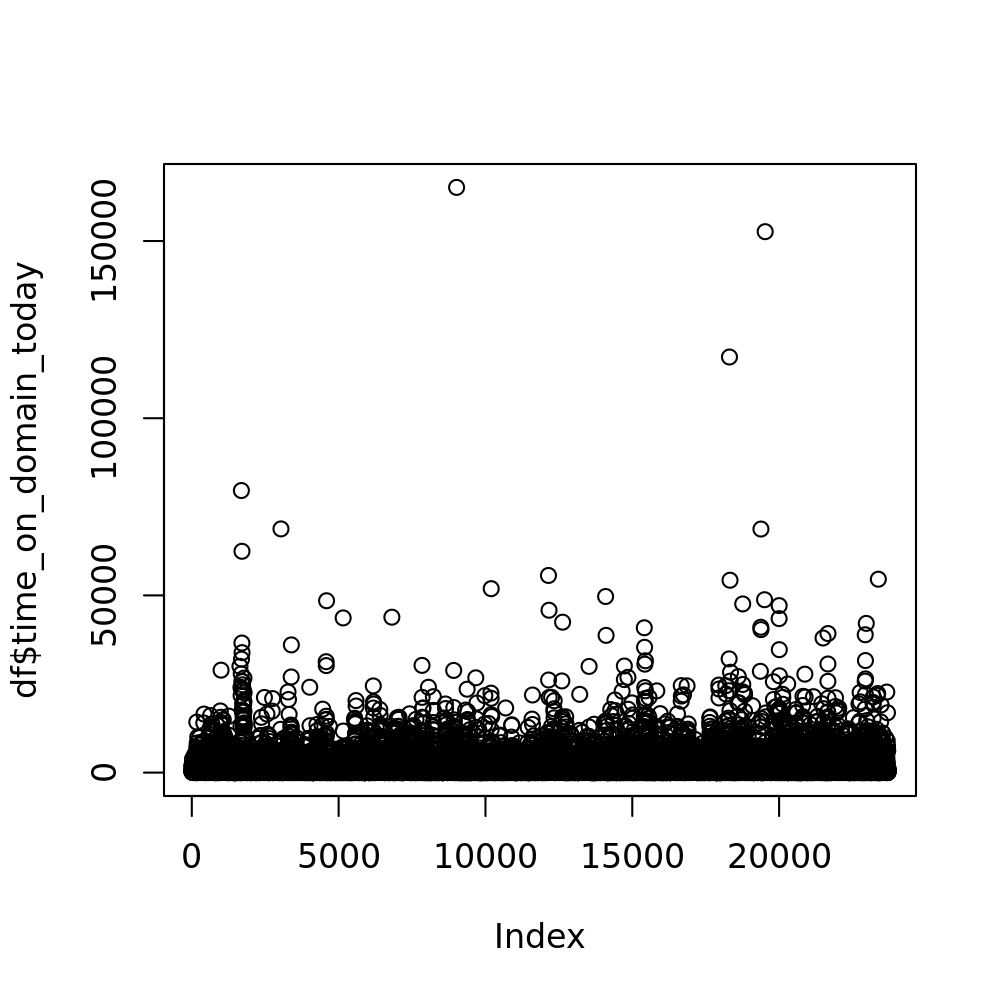

In [10]:
%%R -w 5 -h 5 --units in -r 200


plot(df$time_on_domain_today)

In [11]:
df.dtypes

user                                     object
epoch                                     int64
domain                                   object
time_on_domain_today                      int64
time_on_domain_today_ref                  int64
time_on_all_other_domains_today           int64
time_on_all_other_domains_today_ref       int64
time_on_other_goal_domains_today          int64
time_on_other_goal_domains_today_ref      int64
is_goal_enabled                            bool
is_goal_frequent                           bool
intensity                               float64
intensity_other_goals                   float64
num_days_available_for_user               int64
is_user_unofficial                         bool
have_preview_sessions                      bool
have_suggestion_sessions                   bool
num_sessions_today_for_this_goal          int64
consistent_item                            bool
consistent_day                             bool
consistent_user                         

In [12]:
#ndata = df
#ndata = ndata[ndata['is_goal_enabled'] == True]
#ndata = ndata[ndata['is_goal_frequent'] != 'inconsistent']
#ndata.shape

In [13]:
df

,user,epoch,domain,time_on_domain_today,time_on_domain_today_ref,time_on_all_other_domains_today,time_on_all_other_domains_today_ref,time_on_other_goal_domains_today,time_on_other_goal_domains_today_ref,is_goal_enabled,...,intensity,intensity_other_goals,num_days_available_for_user,is_user_unofficial,have_preview_sessions,have_suggestion_sessions,num_sessions_today_for_this_goal,consistent_item,consistent_day,consistent_user
0,c11e5f2d93f249b5083989b2,953,www.reddit.com,287,333,1996,2309,386,386,True,...,1.000000,1.000000,34,False,False,False,3,False,False,False
1,c11e5f2d93f249b5083989b2,953,www.youtube.com,386,386,1897,2256,287,333,True,...,1.000000,1.000000,34,False,False,False,1,True,False,False
2,c11e5f2d93f249b5083989b2,954,www.reddit.com,392,767,4065,6086,1940,1940,True,...,1.000000,1.000000,34,False,False,False,3,False,False,False
3,c11e5f2d93f249b5083989b2,954,www.youtube.com,1940,1940,2517,4913,392,767,True,...,1.000000,1.000000,34,False,False,False,2,True,False,False
4,c11e5f2d93f249b5083989b2,955,www.reddit.com,1005,584,5003,2669,304,304,True,...,0.666667,0.000000,34,False,False,False,4,False,False,False
5,c11e5f2d93f249b5083989b2,955,www.youtube.com,304,304,5704,2949,1005,584,True,...,0.666667,1.000000,34,False,False,False,2,True,False,False
6,c11e5f2d93f249b5083989b2,956,www.youtube.com,557,557,2161,4254,501,501,True,...,1.000000,1.000000,34,False,False,False,1,True,True,False
7,c11e5f2d93f249b5083989b2,956,www.reddit.com,501,501,2217,4310,557,557,True,...,1.000000,1.000000,34,False,False,False,1,True,True,False
8,c11e5f2d93f249b5083989b2,957,www.youtube.com,2103,2103,4829,2735,285,285,True,...,0.666667,1.000000,34,False,False,False,3,True,True,False
9,c11e5f2d93f249b5083989b2,957,www.reddit.com,285,285,6647,4553,2103,2103,True,...,0.666667,0.000000,34,False,False,False,6,True,True,False


In [14]:
df[df['time_on_all_other_domains_today'] > 24*3600]['user'].unique()

array(['ea891d9cc50061f8a3a35d29', '6216c587462fb5fa9ca9f0e9',
       '5e74926590582e9f959b47c8', 'a80b94f6cad4a1280dfe935a',
       '0cc3e5a34dcb12156268219f'], dtype=object)

In [15]:
df['user'].unique().shape

(1039,)

In [16]:
#%Rpush df

#filename = 'browser_time_on_domains_sept18.csv'
#df = pd.read_csv(filename)

In [17]:
%%R -w 5 -h 5 --units in -r 200

#install.packages('ez')
#install.packages('lme4')

library(lme4)
library(sjPlot)
library(lmerTest)
library(stargazer)
#library(ez)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Learn more about sjPlot with 'browseVignettes("sjPlot")'.

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: 'lmerTest'


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from 'package:lme4':

    lmer


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from 'package:stats':

    step


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Please cite as: 


  warnings.

In [18]:
%%R -w 5 -h 5 --units in -r 200

ndata = df
#ndata = subset(ndata, time_on_domain_today > 8*1000*3600)
#summary(ndata)
summary(ndata)


     user               epoch          domain          time_on_domain_today
 Length:23714       Min.   :947.0   Length:23714       Min.   :     1      
 Class :character   1st Qu.:963.0   Class :character   1st Qu.:   170      
 Mode  :character   Median :971.0   Mode  :character   Median :   632      
                    Mean   :970.6                      Mean   :  1715      
                    3rd Qu.:979.0                      3rd Qu.:  1816      
                    Max.   :986.0                      Max.   :165129      
                                                                           
 time_on_domain_today_ref time_on_all_other_domains_today
 Min.   :    0            Min.   :     0                 
 1st Qu.:  141            1st Qu.:  3956                 
 Median :  595            Median :  7782                 
 Mean   : 1622            Mean   :  9615                 
 3rd Qu.: 1783            3rd Qu.: 13136                 
 Max.   :65150            Max.   :478507    

In [79]:
%%R -w 5 -h 5 --units in -r 200

ndata = df
ndata$domain = as.factor(ndata$domain)
ndata$user = as.factor(ndata$user)
ndata$is_goal_enabled = as.factor(ndata$is_goal_enabled)
ndata$is_goal_frequent = as.factor(ndata$is_goal_frequent)
ndata$log_time_on_domain_today = log(ndata$time_on_domain_today)
ndata$log_time_on_domain_today_ref = log(ndata$time_on_domain_today_ref)
ndata$log_time_on_other_goal_domains_today = log(ndata$time_on_other_goal_domains_today)
ndata$log_time_on_other_goal_domains_today_ref = log(ndata$time_on_other_goal_domains_today_ref)
ndata$log_time_on_all_other_domains_today = log(ndata$time_on_all_other_domains_today)
ndata$log_time_on_all_other_domains_today_ref = log(ndata$time_on_all_other_domains_today_ref)
#ndata = subset(ndata, domain == 'www.facebook.com' | domain == 'www.youtube.com')
#ndata = subset(ndata, domain == 'www.facebook.com')
ndata$log_time_on_other_goal_domains_today[which(!is.finite(ndata$log_time_on_other_goal_domains_today))] <- 0
ndata$log_time_on_all_other_domains_today[which(!is.finite(ndata$log_time_on_all_other_domains_today))] <- 0
ndata$log_time_on_domain_today_ref[which(!is.finite(ndata$log_time_on_domain_today_ref))] <- 0

ndata$log_time_on_domain_today_max = max(ndata$log_time_on_domain_today_ref, ndata$log_time_on_domain_today)

ndata = subset(ndata, is_user_unofficial == FALSE)

#ndata = subset(ndata, num_days_available_for_user > 14)
#ndata = subset(ndata, time_on_domain_today_ref > 5) # exclude preview sessions
#ndata = subset(ndata, time_on_domain_today < 12*3600) # exclude preview sessions
#ndata = subset(ndata, time_on_all_other_domains_today < 12*3600) # exclude preview sessions

#ndata = subset(ndata, consistent_user == TRUE)
#ndata = subset(ndata, consistent_day == TRUE)
#ndata = subset(ndata, consistent_item == TRUE)
ndata = subset(ndata, have_preview_sessions == FALSE)
ndata = subset(ndata, have_suggestion_sessions == FALSE)

ndata_all = ndata
ndata_noyoutube = subset(ndata, domain != 'www.youtube.com')
ndata_youtube = subset(ndata, domain == 'www.youtube.com')
ndata_facebook = subset(ndata, domain == 'www.facebook.com')
ndata_top = subset(ndata, domain == 'www.facebook.com' | domain == 'www.youtube.com' | domain == 'twitter.com' | domain == 'www.reddit.com' | domain == 'mail.google.com' | domain == 'www.amazon.com')
#ndata_top = subset(ndata, domain == 'www.facebook.com' | domain == 'www.youtube.com' | domain == 'twitter.com' | domain == 'www.reddit.com' | domain == 'mail.google.com')
#ndata_top = subset(ndata, domain == 'www.facebook.com' | domain == 'www.youtube.com' | domain == 'twitter.com' | domain == 'www.reddit.com' | domain == 'mail.google.com' | domain == 'www.amazon.com')

ndata = ndata_all
#ndata = ndata_top
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) + (1|user), data = ndata)
summary(results)
#summary(ndata)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | domain) +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 88991.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5746 -0.5135  0.1553  0.6733  3.3773 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.7814   0.8840  
 domain   (Intercept) 0.9594   0.9795  
 Residual             2.5727   1.6040  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.370e+00  3.035e-01  5.384e+00  17.695 5.61e-06 ***
is_goal_frequentTRUE -6.101e-02  2.268e-02  2.289e+04  -2.691  0.00714 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.037


In [20]:
#%%R -w 5 -h 5 --units in -r 200
#plot(ndata$time_on_domain_today)

In [81]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)
#class(results) <- "lmerMod"
#stargazer(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | domain)
   Data: ndata

REML criterion at convergence: 92264

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9142 -0.5727  0.1522  0.7178  3.0276 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept) 1.026    1.013   
 Residual             3.203    1.790   
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.426e+00  3.129e-01  4.936e+00  17.343  1.3e-05 ***
is_goal_frequentTRUE -5.559e-02  2.363e-02  2.302e+04  -2.352   0.0187 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.035


In [82]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals +  
    (1 | domain)
   Data: ndata

REML criterion at convergence: 69971.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9478 -0.5686  0.1575  0.7166  3.0690 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept) 1.022    1.011   
 Residual             3.111    1.764   
Number of obs: 17597, groups:  domain, 13

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.508e+00  3.162e-01  4.193e+00  17.418 4.53e-05 ***
is_goal_frequentTRUE  -7.096e-02  2.666e-02  1.758e+04  -2.661  0.00779 ** 
intensity_other_goals -4.415e-02  3.395e-02  1.757e+04  -1.300  0.19350    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) i__TRU
is_gl_fTRUE -0.039       
intnsty_th

In [83]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_all_other_domains_today ~ is_goal_frequent + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_all_other_domains_today ~ is_goal_frequent + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 76162.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.1585 -0.3477  0.1859  0.5927  3.4955 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept) 0.02582  0.1607  
 Residual             1.59403  1.2625  
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           8.811e+00  5.773e-02  8.666e+00 152.614 3.64e-16 ***
is_goal_frequentTRUE -1.770e-02  1.667e-02  2.304e+04  -1.062    0.288    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.136


In [24]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 119023.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1504 -0.9448  0.3317  0.7690  2.2929 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept)  0.6745  0.8213  
 Residual             10.2395  3.1999  
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           6.092e+00  2.742e-01  8.971e+00   22.22 3.75e-09 ***
is_goal_frequentTRUE -1.604e-02  4.225e-02  2.303e+04   -0.38    0.704    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.072


In [25]:
#%%R -w 5 -h 5 --units in -r 200

#ndata = df
#subset(ndata, time_on_domain_today == 105384637)

In [26]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user)
   Data: ndata

REML criterion at convergence: 29442.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6467 -0.4680  0.1325  0.6127  4.4570 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.459    1.208   
 Residual             1.558    1.248   
Number of obs: 8458, groups:  user, 824

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             5.81207    0.04899  866.25125 118.648  < 2e-16 ***
is_goal_frequentTRUE   -0.08437    0.03180 8222.03007  -2.654  0.00798 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.308


In [27]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user) + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 88991.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5746 -0.5135  0.1553  0.6733  3.3773 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.7814   0.8840  
 domain   (Intercept) 0.9594   0.9795  
 Residual             2.5727   1.6040  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.370e+00  3.035e-01  5.384e+00  17.695 5.61e-06 ***
is_goal_frequentTRUE -6.101e-02  2.268e-02  2.289e+04  -2.691  0.00714 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.037


In [28]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 19882

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2288 -0.4633  0.1306  0.6032  3.4868 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.436    1.198   
 Residual             1.459    1.208   
Number of obs: 5770, groups:  user, 696

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              6.03884    0.05955 1103.17410 101.405  < 2e-16 ***
is_goal_frequentTRUE    -0.09414    0.03769 5579.57584  -2.497   0.0125 *  
intensity_other_goals   -0.18455    0.04619 5594.16891  -3.995 6.55e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) i__TRU
is_gl_fTRUE -0.286       
intnsty_th_ -0.4

In [29]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals + (1|user) + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals +  
    (1 | user) + (1 | domain)
   Data: ndata

REML criterion at convergence: 68087.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4965 -0.5334  0.1496  0.6806  3.3863 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.5928   0.7699  
 domain   (Intercept) 0.9918   0.9959  
 Residual             2.6142   1.6169  
Number of obs: 17597, groups:  user, 792; domain, 13

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.402e+00  3.127e-01  4.562e+00  17.277 2.48e-05 ***
is_goal_frequentTRUE  -7.317e-02  2.594e-02  1.754e+04  -2.821  0.00479 ** 
intensity_other_goals -2.539e-02  3.393e-02  1.757e+04  -0.748  0.45429    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects

In [30]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_youtube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 21381.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4436 -0.4796  0.1482  0.6233  3.2721 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.568    1.252   
 Residual             2.338    1.529   
Number of obs: 5500, groups:  user, 709

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              6.39265    0.06893 1362.41701  92.746   <2e-16 ***
is_goal_frequentTRUE    -0.06102    0.04927 5448.42330  -1.239    0.216    
intensity_other_goals    0.01112    0.05996 5396.12048   0.186    0.853    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) i__TRU
is_gl_fTRUE -0.332       
intnsty_th_ -0

In [31]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
summary(ndata)


                       user           epoch                    domain    
 c765fb71d498eb3846f03cd9:  163   Min.   :947.0   www.facebook.com:8458  
 37615573eea8075a109f0bef:  118   1st Qu.:963.0   www.youtube.com :7403  
 17e7de4f422a37ce6b911178:  117   Median :971.0   twitter.com     :2469  
 370c2e73147e37d2db03e788:  114   Mean   :970.6   www.reddit.com  :1629  
 8003c4d51219e6c8d11e4502:  114   3rd Qu.:979.0   mail.google.com :1524  
 1a15ab8c5d0ef03d6e813dc1:  112   Max.   :986.0   www.amazon.com  : 924  
 (Other)                 :22302                   (Other)         : 633  
 time_on_domain_today time_on_domain_today_ref time_on_all_other_domains_today
 Min.   :     1       Min.   :    0            Min.   :     0                 
 1st Qu.:   169       1st Qu.:  139            1st Qu.:  3981                 
 Median :   624       Median :  590            Median :  7809                 
 Mean   :  1713       Mean   : 1623            Mean   :  9638                 
 3rd Qu.:  18

In [32]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | domain) +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 57638.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6353 -0.4931  0.1429  0.6442  3.5458 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.9694   0.9846  
 domain   (Intercept) 1.0669   1.0329  
 Residual             2.0894   1.4455  
Number of obs: 15637, groups:  user, 943; domain, 13

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.162e+00  3.322e-01  4.968e+00  15.539 2.11e-05 ***
is_goal_frequentTRUE -6.306e-02  2.543e-02  1.547e+04  -2.479   0.0132 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.038


In [33]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | domain) +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 57638.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6353 -0.4931  0.1429  0.6442  3.5458 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.9694   0.9846  
 domain   (Intercept) 1.0669   1.0329  
 Residual             2.0894   1.4455  
Number of obs: 15637, groups:  user, 943; domain, 13

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.162e+00  3.322e-01  4.968e+00  15.539 2.11e-05 ***
is_goal_frequentTRUE -6.306e-02  2.543e-02  1.547e+04  -2.479   0.0132 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.038


In [34]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | domain)
   Data: ndata

REML criterion at convergence: 60948

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1379 -0.5588  0.1442  0.7088  3.1805 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept) 1.227    1.108   
 Residual             2.876    1.696   
Number of obs: 15637, groups:  domain, 13

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.204e+00  3.538e-01  4.546e+00  14.707 5.24e-05 ***
is_goal_frequentTRUE -3.241e-02  2.720e-02  1.562e+04  -1.192    0.233    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.035


In [35]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals + (1|user) + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + intensity_other_goals +  
    (1 | user) + (1 | domain)
   Data: ndata

REML criterion at convergence: 44772.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5564 -0.4950  0.1431  0.6529  3.5532 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.8819   0.9391  
 domain   (Intercept) 1.0860   1.0421  
 Residual             2.1255   1.4579  
Number of obs: 12097, groups:  user, 790; domain, 12

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.309e+00  3.408e-01  4.321e+00  15.580 5.83e-05 ***
is_goal_frequentTRUE  -7.505e-02  2.895e-02  1.197e+04  -2.592  0.00955 ** 
intensity_other_goals -9.893e-02  3.852e-02  1.207e+04  -2.568  0.01023 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects

In [36]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user)
   Data: ndata

REML criterion at convergence: 29442.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6467 -0.4680  0.1325  0.6127  4.4570 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.459    1.208   
 Residual             1.558    1.248   
Number of obs: 8458, groups:  user, 824

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             5.81207    0.04899  866.25125 118.648  < 2e-16 ***
is_goal_frequentTRUE   -0.08437    0.03180 8222.03007  -2.654  0.00798 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.308


In [37]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_youtube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user)
   Data: ndata

REML criterion at convergence: 29067.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5887 -0.4871  0.1548  0.6300  3.1808 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.583    1.258   
 Residual             2.468    1.571   
Number of obs: 7403, groups:  user, 841

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             6.34175    0.05461 1021.38188 116.133   <2e-16 ***
is_goal_frequentTRUE   -0.05386    0.04374 7361.35806  -1.231    0.218    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.390


In [38]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user) + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 57638.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6353 -0.4931  0.1429  0.6442  3.5458 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.9694   0.9846  
 domain   (Intercept) 1.0669   1.0329  
 Residual             2.0894   1.4455  
Number of obs: 15637, groups:  user, 943; domain, 13

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.162e+00  3.322e-01  4.968e+00  15.539 2.11e-05 ***
is_goal_frequentTRUE -6.306e-02  2.543e-02  1.547e+04  -2.479   0.0132 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.038


In [39]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user) + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 88991.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5746 -0.5135  0.1553  0.6733  3.3773 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.7814   0.8840  
 domain   (Intercept) 0.9594   0.9795  
 Residual             2.5727   1.6040  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.370e+00  3.035e-01  5.384e+00  17.695 5.61e-06 ***
is_goal_frequentTRUE -6.101e-02  2.268e-02  2.289e+04  -2.691  0.00714 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.037


In [40]:
%%R -w 5 -h 5 --units in -r 200

#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_domain_today ~ is_goal_frequent + (1 | user) + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 88991.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5746 -0.5135  0.1553  0.6733  3.3773 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.7814   0.8840  
 domain   (Intercept) 0.9594   0.9795  
 Residual             2.5727   1.6040  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           5.370e+00  3.035e-01  5.384e+00  17.695 5.61e-06 ***
is_goal_frequentTRUE -6.101e-02  2.268e-02  2.289e+04  -2.691  0.00714 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.037


In [41]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 29286.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3590 -0.4686  0.1295  0.6050  4.3011 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.493    1.222   
 Residual             1.523    1.234   
Number of obs: 8458, groups:  user, 824

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           5.474e+00  5.568e-02  1.315e+03  98.304
is_goal_frequentTRUE                 -8.871e-02  3.146e-02  8.207e+03  -2.819
log_time_on_other_goal_domains_today  7.287e-02  5.641e-03  8.414e+03  12.920
                                     Pr(>|t|)    
(Intercept)                           < 2e-16 ***
is_goal_frequentTRUE                  

In [42]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_youtube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) +  
    (1 | user)
   Data: ndata

REML criterion at convergence: 28992.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5684 -0.4878  0.1508  0.6282  3.2153 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.657    1.287   
 Residual             2.428    1.558   
Number of obs: 7403, groups:  user, 841

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           5.962e+00  6.878e-02  1.894e+03  86.687
is_goal_frequentTRUE                 -4.606e-02  4.348e-02  7.346e+03  -1.059
log_time_on_other_goal_domains_today  7.961e-02  8.653e-03  6.595e+03   9.200
                                     Pr(>|t|)    
(Intercept)                            <2e-16 ***
is_goal_frequentTRUE                  

In [43]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user) + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) +  
    (1 | user) + (1 | domain)
   Data: ndata

REML criterion at convergence: 57624.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6430 -0.4867  0.1436  0.6440  3.5532 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.9535   0.9765  
 domain   (Intercept) 1.0944   1.0461  
 Residual             2.0881   1.4450  
Number of obs: 15637, groups:  user, 943; domain, 13

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           5.038e+00  3.368e-01  5.089e+00  14.960
is_goal_frequentTRUE                 -6.353e-02  2.542e-02  1.547e+04  -2.499
log_time_on_other_goal_domains_today  2.330e-02  4.960e-03  1.423e+04   4.698
                                     Pr(>|t|)    
(Intercept)         

In [44]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user) + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) +  
    (1 | user) + (1 | domain)
   Data: ndata

REML criterion at convergence: 88930

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5441 -0.5147  0.1558  0.6748  3.3674 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 0.8482   0.9210  
 domain   (Intercept) 0.8958   0.9464  
 Residual             2.5574   1.5992  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           5.559e+00  2.952e-01  5.374e+00  18.831
is_goal_frequentTRUE                 -6.124e-02  2.263e-02  2.286e+04  -2.706
log_time_on_other_goal_domains_today -3.701e-02  4.342e-03  2.027e+04  -8.525
                                     Pr(>|t|)    
(Intercept)          

In [45]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lm(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today), data = ndata)
summary(results)


Call:
lm(formula = log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today), 
    data = ndata)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3394 -0.9079  0.2480  1.1528  4.3964 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           6.02530    0.03443 175.014  < 2e-16 ***
is_goal_frequentTRUE                 -0.04317    0.03620  -1.193    0.233    
log_time_on_other_goal_domains_today  0.03281    0.00514   6.382 1.84e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.661 on 8455 degrees of freedom
Multiple R-squared:  0.00495,	Adjusted R-squared:  0.004715 
F-statistic: 21.03 on 2 and 8455 DF,  p-value: 7.735e-10



In [46]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_youtube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lm(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today), data = ndata)
summary(results)


Call:
lm(formula = log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today), 
    data = ndata)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.7090 -1.1949  0.3383  1.4473  5.4321 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           6.631697   0.047654 139.165   <2e-16 ***
is_goal_frequentTRUE                 -0.103689   0.045896  -2.259   0.0239 *  
log_time_on_other_goal_domains_today  0.008753   0.007090   1.234   0.2171    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.973 on 7400 degrees of freedom
Multiple R-squared:  0.0009058,	Adjusted R-squared:  0.0006358 
F-statistic: 3.355 on 2 and 7400 DF,  p-value: 0.03498



In [47]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_noyoutube
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) +  
    (1 | domain)
   Data: ndata

REML criterion at convergence: 60874.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2042 -0.5572  0.1440  0.7080  3.1953 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept) 1.264    1.124   
 Residual             2.861    1.691   
Number of obs: 15637, groups:  domain, 13

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           4.956e+00  3.593e-01  4.738e+00  13.793
is_goal_frequentTRUE                 -3.321e-02  2.713e-02  1.562e+04  -1.224
log_time_on_other_goal_domains_today  3.865e-02  4.250e-03  1.562e+04   9.093
                                     Pr(>|t|)    
(Intercept)                          5.26e-05 ***
is_goal_frequentTRUE              

In [48]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) +  
    (1 | domain)
   Data: ndata

REML criterion at convergence: 92212

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9589 -0.5700  0.1491  0.7117  3.0675 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept) 1.067    1.033   
 Residual             3.195    1.787   
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           5.239e+00  3.191e-01  5.099e+00  16.418
is_goal_frequentTRUE                 -5.513e-02  2.360e-02  2.302e+04  -2.336
log_time_on_other_goal_domains_today  2.885e-02  3.681e-03  2.303e+04   7.839
                                     Pr(>|t|)    
(Intercept)                          1.31e-05 ***
is_goal_frequentTRUE                

In [49]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 119023.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1504 -0.9448  0.3317  0.7690  2.2929 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept)  0.6745  0.8213  
 Residual             10.2395  3.1999  
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           6.092e+00  2.742e-01  8.971e+00   22.22 3.75e-09 ***
is_goal_frequentTRUE -1.604e-02  4.225e-02  2.303e+04   -0.38    0.704    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.072


In [50]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|domain) + (1|user), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    domain) + (1 | user)
   Data: ndata

REML criterion at convergence: 107357.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8078 -0.4002  0.1070  0.6009  3.4213 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 6.3924   2.5283  
 domain   (Intercept) 0.2178   0.4667  
 Residual             5.4321   2.3307  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           4.391e+00  1.811e-01  1.271e+01  24.249 5.05e-12 ***
is_goal_frequentTRUE -3.549e-03  3.329e-02  2.241e+04  -0.107    0.915    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.090


In [51]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 119023.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1504 -0.9448  0.3317  0.7690  2.2929 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept)  0.6745  0.8213  
 Residual             10.2395  3.1999  
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           6.092e+00  2.742e-01  8.971e+00   22.22 3.75e-09 ***
is_goal_frequentTRUE -1.604e-02  4.225e-02  2.303e+04   -0.38    0.704    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.072


In [52]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|user), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    user)
   Data: ndata

REML criterion at convergence: 40363.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4181 -0.4164  0.0544  0.5769  3.7571 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 6.934    2.633   
 Residual             5.538    2.353   
Number of obs: 8458, groups:  user, 824

Fixed effects:
                      Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)          4.589e+00  1.036e-01 9.239e+02  44.306   <2e-16 ***
is_goal_frequentTRUE 6.358e-02  6.026e-02 8.151e+03   1.055    0.291    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.276


In [53]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    domain)
   Data: ndata

REML criterion at convergence: 119023.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1504 -0.9448  0.3317  0.7690  2.2929 

Random effects:
 Groups   Name        Variance Std.Dev.
 domain   (Intercept)  0.6745  0.8213  
 Residual             10.2395  3.1999  
Number of obs: 23040, groups:  domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           6.092e+00  2.742e-01  8.971e+00   22.22 3.75e-09 ***
is_goal_frequentTRUE -1.604e-02  4.225e-02  2.303e+04   -0.38    0.704    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.072


In [54]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_all
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|user) + (1|domain), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    user) + (1 | domain)
   Data: ndata

REML criterion at convergence: 107357.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8078 -0.4002  0.1070  0.6009  3.4213 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 6.3924   2.5283  
 domain   (Intercept) 0.2178   0.4667  
 Residual             5.4321   2.3307  
Number of obs: 23040, groups:  user, 1037; domain, 14

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           4.391e+00  1.811e-01  1.271e+01  24.249 5.05e-12 ***
is_goal_frequentTRUE -3.549e-03  3.329e-02  2.241e+04  -0.107    0.915    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.090


In [55]:
%%R -w 5 -h 5 --units in -r 200

ndata = ndata_facebook
#results <- lmer(time_on_domain_today ~ is_goal_frequent + (time_on_other_goal_domains_today) + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user) + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|domain) , data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (1|user), data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lm(log_time_on_domain_today ~ is_goal_frequent, data = ndata)
#results <- lmer(log_time_on_domain_today ~ is_goal_frequent + (log_time_on_other_goal_domains_today) + (1|user), data = ndata)
results <- lmer(log_time_on_other_goal_domains_today ~ is_goal_frequent + (1|user), data = ndata)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_time_on_other_goal_domains_today ~ is_goal_frequent + (1 |  
    user)
   Data: ndata

REML criterion at convergence: 40363.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4181 -0.4164  0.0544  0.5769  3.7571 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 6.934    2.633   
 Residual             5.538    2.353   
Number of obs: 8458, groups:  user, 824

Fixed effects:
                      Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)          4.589e+00  1.036e-01 9.239e+02  44.306   <2e-16 ***
is_goal_frequentTRUE 6.358e-02  6.026e-02 8.151e+03   1.055    0.291    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
is_gl_fTRUE -0.276
